# CT Tomography - aka Inverse Linear Radon transform

In this notebook we experiment with a couple of different ways to setup a Linear Radon transform and perform its inverse transform as the solutiion of an inverse problem

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import SplitBregman

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## scikit-image Radon

First let's import the famous Shepp Logan image

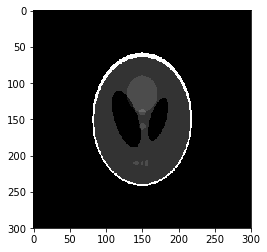

In [14]:
image = shepp_logan_phantom()[::2, ::2]
image = np.pad(image, ((50, 50), (50, 50)))
plt.imshow(image, cmap='gray');

First thing we do is to use scikit-image Radon functionality to see what we can do with them

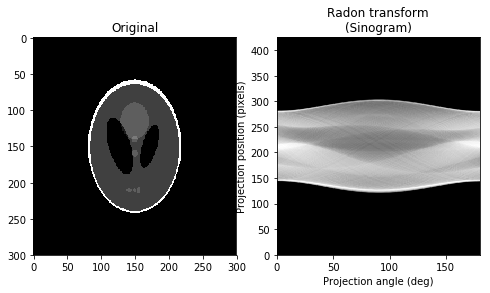

In [15]:
thetas = np.arange(0, 180, 1)
sinogram = radon(image, theta=thetas, circle=False, preserve_range=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image, cmap=plt.cm.Greys_r)
ax1.set_title("Original")
ax1.axis('tight')
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]))
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.axis('tight');

Now we use their iradon reconstruction which is based on the famous Filtered Back Projection (FBP)

FBP rms reconstruction error: 0.0322


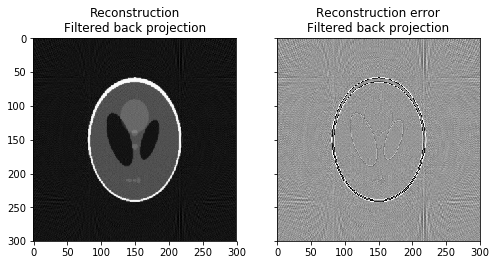

In [16]:
image_fbp = iradon(sinogram, theta=thetas, circle=False)
error_fbp = image_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error_fbp**2)):.3g}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(image_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(image_fbp - image, cmap=plt.cm.Greys_r, vmin=-0.2, vmax=0.2);

Now we want to see if we can take advantage of the radon-iradon pair to create a PyLops operator. Note that iradon is most likely an approximation to the inverse of radon but what we want to see is if taking away the filter, what comes out from iradon can be used as the adjoint of radon.

We know that lots of attention must be placed to make and adjoint from the forward, so we dont expect this pair to pass the dot-test, but who know... let's give it a try!

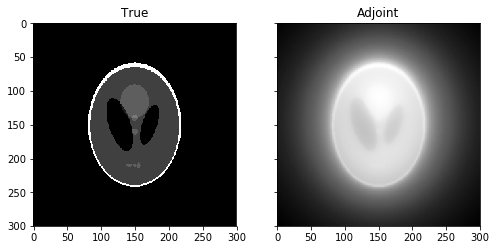

In [17]:
mvec = lambda x: radon(x.reshape(image.shape), theta=thetas, circle=False, preserve_range=False)
rmvec = lambda x: iradon(x.reshape(sinogram.shape), theta=thetas, circle=False,
                         filter=None, interpolation='nearest')
Fop = FunctionOperator(mvec, rmvec, sinogram.size, image.size)

sinogram1 = Fop * image.ravel()
sinogram1 = sinogram1.reshape(sinogram1.shape)

imageadj = Fop.H * sinogram1.ravel()
imageadj = imageadj.reshape(image.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("True")
ax1.imshow(image, cmap=plt.cm.Greys_r)
ax2.set_title("Adjoint")
ax2.imshow(imageadj, cmap=plt.cm.Greys_r);

In [18]:
dottest(Fop, Fop.shape[0], Fop.shape[1])

ValueError: Dot test failed, v^T(Opu)=-1614.212197 - u^T(Op^Tv)=-25.057359

What we learned here. Well, iradon without filter looks very much like an adjoint. You can see the very low frequency reconstruction which is indeed missing a filter to make it closer to an inverse than an adjoint.

But we know that radon in scikit-image works with the following strategy:

```
for each theta
    rotate image by theta
    sum over horizontal axis
```

and to be able to get a proper adjoint something like this should be implemented

```
for each theta
    spread over horizontal axis
    rotate image by -theta
```

We see that the dot-test is not passed, so probably something in the iradon is done cutting some corners and it is not exactly the adjoint of the radon

What does this means? If we take our operator ``Fop`` that doesn't pass the dot-test and feed it to a solver, we will likely get problems converging to a good solution. Let's try...

L2 Reg rms reconstruction error: 0.163


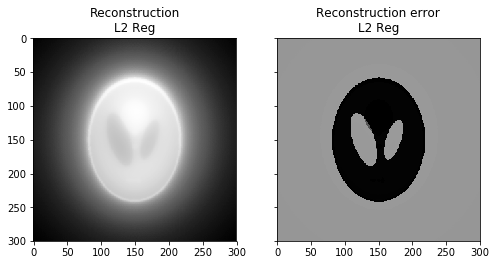

In [19]:
D2op = Laplacian(dims=image.shape, edge=True, dtype=np.float)

# L2
image_sm = RegularizedInversion(Fop, [D2op], sinogram.flatten(), epsRs=[1e-10],
                                **dict(iter_lim=100))
image_sm = image_sm.reshape(image.shape)

error = image_sm - image
print(f"L2 Reg rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.imshow(image_sm, cmap=plt.cm.Greys_r)
ax1.set_title("Reconstruction\nL2 Reg")
ax2.imshow(image_sm - image, cmap=plt.cm.Greys_r, vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nL2 Reg");

Ok this doesn't seem to converge. Not sursprising as we did not pass the dot-test.

We have now two possible routes:
    
- use some of PyLops operators to create something along the line of scikit-image radon. We know that if we can achieve that, we will have a correct adjoint for free, as PyLops knows how to make the adjoint of any of its operators and has rules for making it when you combine core operators together by means of sum, multiply, stack etc.
- use PyLops version of Radon. We must be aware it is not fully intended for medical applications and to that extent we may need it to twick it a bit

## scikit-image like Radon

Let's start from the first scenario.

First we see how we can perform the rotation + stacking using operators already provided in PyLops. We will use our `Bilinear` to act as a coordinate rotation and the `Sum` operator to stack over an axis.

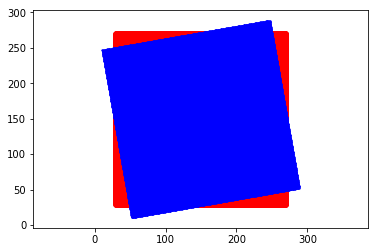

In [20]:
nx = 300
ny = 300
pad = 60

# define axis for rotation via bilinear interpolation
x0, y0 = nx//2, ny//2
x = np.arange(nx - pad) - x0 + pad//2
y = np.arange(ny - pad) - y0 + pad//2
z = np.zeros((nx, ny))
X, Y = np.meshgrid(x, y, indexing='ij')
X, Y = X.ravel(), Y.ravel()
XY = np.vstack((X, Y))

# create padded image
z[pad//2:-pad//2, pad//2:-pad//2] = image[pad//2:nx-pad//2, pad//2:ny-pad//2]

# rotate
theta = 10
theta = np.deg2rad(theta)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
XYrot = R @ XY

# recenter to positive axes
XY[0] += x0
XY[1] += y0

XYrot[0] += x0
XYrot[1] += y0

plt.figure()
plt.scatter(XY[0] , XY[1], c='r')
plt.scatter(XYrot[0], XYrot[1], c='b', s=2)
plt.axis('equal');

Create the rotation operator

In [21]:
Rop = Bilinear(XYrot, dims=(nx, ny))

Rotate the image

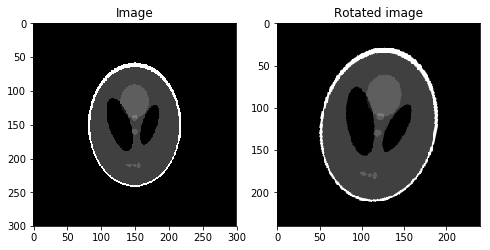

In [22]:
zrot = Rop * z.ravel()
zrot = zrot.reshape(nx-pad, ny-pad)
sigm  = Fop * z.ravel()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.imshow(z, cmap=plt.cm.Greys_r)
ax1.set_title("Image")
ax2.imshow(zrot, cmap=plt.cm.Greys_r)
ax2.set_title("Rotated image");

You see that we need some extra padding to allow the rotation as we need all the rotated samples to still be within the original grid of our Bilinear interpolator... we can probably do better by just choosing samples within the bounding box without having to do some extra padding, but for now we don't care too much about it

Let's now make a routine that applies repeated rotations and sums for all angles

In [23]:
def RadonRotate(dims, pad, thetas):
    nx, ny = dims
    x0, y0 = nx//2, ny//2
    x = np.arange(nx - pad) - x0 + pad//2
    y = np.arange(ny - pad) - y0 + pad//2
    z = np.zeros((nx, ny))
    z[pad//2:-pad//2, pad//2:-pad//2] = image[pad//2:nx-pad//2, pad//2:ny-pad//2]
    X, Y = np.meshgrid(x, y, indexing='ij')
    X, Y = X.ravel(), Y.ravel()
    XY = np.vstack((X, Y))

    thetas = np.deg2rad(thetas)
    Rops = []
    for theta in thetas:
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        XYrot = R @ XY

        # recenter to positive axes
        XYrot[0] += x0
        XYrot[1] += y0

        Rops.append(Sum(dims=(nx-pad, ny-pad), dir=0) * Bilinear(XYrot, dims=(nx, ny)))
    Radop = VStack(Rops)

    return Radop

In [24]:
pad = 100
thetas = np.arange(0, 180, 2)

Radop = RadonRotate((nx, ny), pad, thetas)
rad = Radop * z.ravel()
rad = rad.reshape(len(thetas), ny-pad)

In [25]:
sinogram = radon(z, theta=thetas, circle=False)
sinogram = sinogram[sinogram.shape[0]//2-(nx-pad)//2:sinogram.shape[0]//2+(nx-pad)//2]

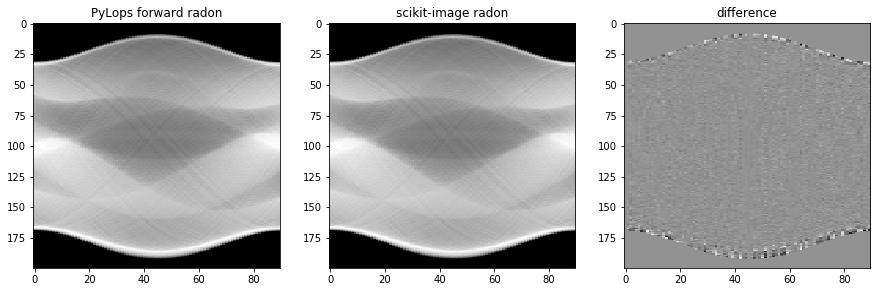

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(rad.T, cmap=plt.cm.Greys_r)
ax1.set_title("PyLops forward radon")
ax1.axis("tight")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)
ax2.set_title("scikit-image radon")
ax2.axis("tight")
ax3.imshow(rad.T-sinogram, cmap=plt.cm.Greys_r)
ax3.set_title("difference")
ax3.axis("tight");

As you can see we have pretty much produced the same result but we have now something that has also a proper adjoint.

Let's see if we can now feed it into one of PyLops solver and get a better inverse than before

In [27]:
image_adj = Radop.H * rad.ravel()
image_adj = image_adj.reshape(nx, ny)

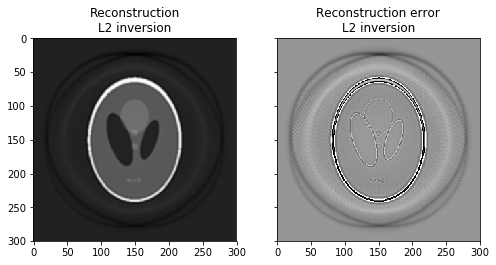

In [31]:
Dop = [FirstDerivative(ny*nx, dims=(nx, ny), dir=0, edge=True, kind='backward', dtype=np.float),
       FirstDerivative(ny*nx, dims=(nx, ny), dir=1, edge=True, kind='backward', dtype=np.float)]
D2op = Laplacian(dims=(nx, ny), edge=True, dtype=np.float)

# L2
image_l2 = RegularizedInversion(Radop, [D2op], rad.ravel(), epsRs=[1e1],
                            **dict(iter_lim=20))
image_l2 = np.real(image_l2.reshape(nx, ny))
error_l2 = image_l2 - image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nL2 inversion")
ax1.imshow(image_l2, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nL2 inversion")
ax2.imshow(image_l2 - image, cmap=plt.cm.Greys_r, vmin=-0.2, vmax=0.2);

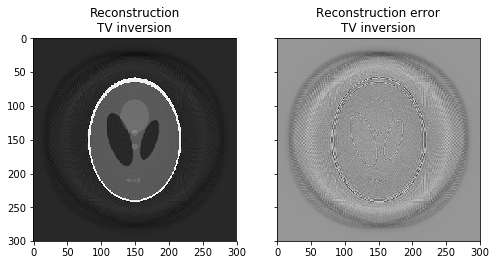

In [33]:
# TV
mu = 1.5
lamda = [1., 1.]
niter = 10
niterinner = 2

image_tv, niter = SplitBregman(Radop, Dop, rad.ravel(), niter, niterinner,
                           mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=True,
                             **dict(iter_lim=10, damp=1e-2))
image_tv = np.real(image_tv.reshape(nx, ny))
error_tv = image_tv - image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nTV inversion")
ax1.imshow(image_tv, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nTV inversion")
ax2.imshow(image_tv - image, cmap=plt.cm.Greys_r, vmin=-0.2, vmax=0.2);

L2 reconstruction error: 0.0502
TV reconstruction error: 0.0213


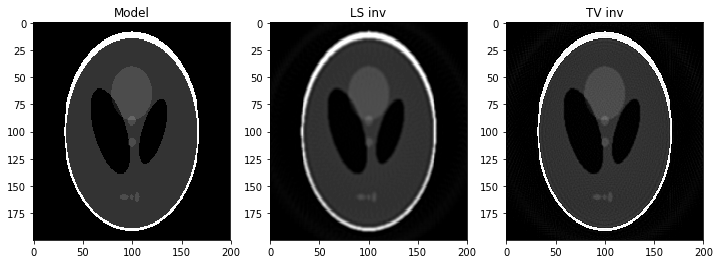

In [37]:
error_ls = image_l2 - image
error_tv = image_tv - image

print(f"L2 reconstruction error: {np.sqrt(np.mean(error_ls**2)):.3g}")
print(f"TV reconstruction error: {np.sqrt(np.mean(error_tv**2)):.3g}")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('LS inv')
axs[2].imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[2].set_title('TV inv');

What we see is that we can invert our sinogram. When doing it with a L2 solver we get a decent result but the image is a bit blurred. If we add now a TV regularization the image is much sharper and the reconstruction error is even smaller than

## PyLops Radon

Our definition of Radon is sligtly different as we use the Spread operator that is parametrized in $x,y$ instead of $r,\theta$. For this reason we first need reparametrize the curve over which summation will be peformed to be function of r and $\theta$:

$$ t(x) = tan(90-\theta)*x + r/sin(\theta) $$

At this point we can use the `Spread` operator like done in our `Radon2D`. This approach is much faster than the one investigated in the previous section as our `Spread` operator uses numba and parallizes compuatations over different angles.

In [38]:
from pylops.signalprocessing.Radon2D import _indices_2d

def radoncurve(x, r, theta):
    return r/np.sin(np.deg2rad(theta)) + np.tan(np.deg2rad(90 - theta))*x

def create_table(f, x, taxis, thetaaxis, nx, nt, ntheta):
    """Create look up table
    """
    t0 = taxis[0]
    table = np.full((ntheta, nt, nx), np.nan, dtype=np.float32)
    for itheta, theta in enumerate(thetaaxis):
        for it, t in enumerate(taxis):
            tdecscan = f(x, it + t0, theta) - t0
            xscan = (tdecscan >= 0) & (tdecscan < nt - 1)
            tscan = tdecscan[xscan].astype(np.int)
            table[itheta, it, xscan] = tscan
    return table

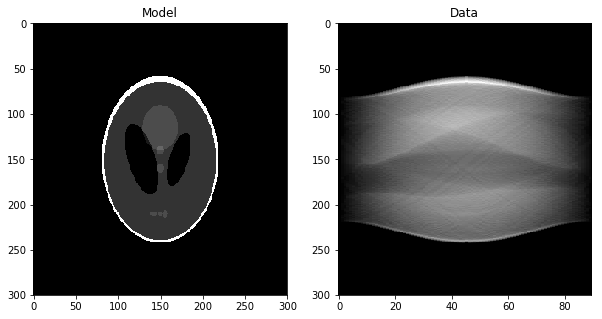

In [39]:
ntheta = thetas.size
ny, nx = image.shape

table = create_table(radoncurve, np.arange(ny) - ny//2, np.arange(nx) - nx//2, 
                     thetas, ny, nx, ntheta)
Fop = pylops.Spread((ntheta, nx), (ny, nx), table=table, engine='numba', interp=True)

sinogram = Fop.H*image.T.ravel()
sinogram = sinogram.reshape(ntheta, nx).T

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(sinogram, cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight');

We can see that while for the middle angles this operator behaves in the same way as the previous one based on rotation+summation, this is not the case for very low (or very high angles). This is because our parametrization does not allow summation over vertical (or near vertical) lines when $sin(\theta) \rarrow 0$.

As a way to mitigate this problem, we can simply split our transform in 2. One acts on the image, the other on the transpose image (a summation over horizontal lines here is in fact equivalent to a summation over vertical lines in the original image).

In [43]:
theta1 = np.linspace(45., 135., ntheta // 2, endpoint=False)
ntheta1 = theta1.size

ny, nx = image.shape

table = create_table(radoncurve, np.arange(ny) - ny//2, np.arange(nx) - nx//2, 
                     theta1, ny, nx, theta1.size)

F1op = Spread((theta1.size, nx), (ny, nx), table=table, engine='numba', interp=True)
F2op = Spread((theta1.size, nx), (ny, nx), table=table, engine='numba', interp=True)
Top = Transpose(image.shape, axes=(1, 0))
Fop = HStack([F1op, Top*F2op])

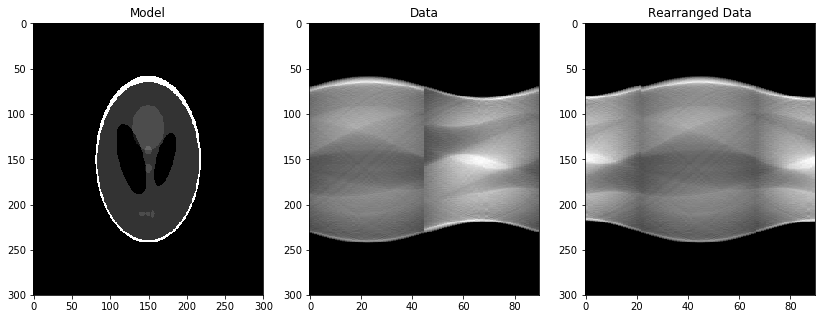

In [44]:
sinogram = Fop.H*image.T.ravel()
sinogram = sinogram.reshape(thetas.size, nx).T

# rearrange for visualization
sinogram_viz = np.hstack([np.flipud(np.fliplr(sinogram[:, ntheta1:3*ntheta1//2])), 
                          sinogram[:, :ntheta1], np.fliplr(sinogram[:, 3*ntheta1//2:])])

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(sinogram, cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(sinogram_viz, cmap='gray')
axs[2].set_title('Rearranged Data')
axs[2].axis('tight');

Let's finally use this transform as the forward Radon in an inversion process

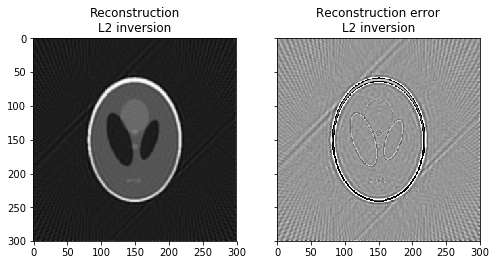

In [45]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, kind='backward', dtype=np.float),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, kind='backward', dtype=np.float)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.float)

# L2
image_l2 = RegularizedInversion(Fop.H, [D2op], sinogram.T.flatten(), epsRs=[1e1],
                               **dict(iter_lim=20))
image_l2 = np.real(image_l2.reshape(nx, ny)).T
error_l2 = image_l2 - image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nL2 inversion")
ax1.imshow(image_l2, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nL2 inversion")
ax2.imshow(image_l2 - image, cmap=plt.cm.Greys_r, vmin=-0.2, vmax=0.2);

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 27000 rows and 90000 cols
niter_outer =  10     niter_inner =   2   tol = 1.00e-04
mu = 1.50e+00         epsL1 = [1.0, 1.0]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   5.16994e-02        1.320e+01        6.688e+03
     2   5.09829e-02        8.090e+00        5.191e+03
     3   4.85456e-02        1.087e+01        5.092e+03
     4   4.65163e-02        1.413e+01        4.305e+03
     5   4.27442e-02        1.480e+01        3.271e+03
     6   3.54292e-02        1.615e+01        2.697e+03
     7   2.50893e-02        1.188e+01        2.918e+03
     8   1.24531e-02        1.239e+01        3.332e+03
     9   1.13206e-03        9.505e+00        3.471e+03
    10  -9.22016e-03        8.904e+00        3.357e+03

Iterations = 10        Total time (s) = 33.64
----------------------------------------

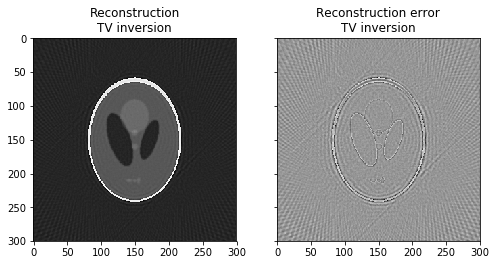

In [49]:
# TV
mu = 1.5
lamda = [1., 1.]
niter = 10
niterinner = 2

image_tv, niter = SplitBregman(Fop.H, Dop, sinogram.T.flatten(), niter, niterinner,
                               mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=True,
                               **dict(iter_lim=20, damp=1e-2))
image_tv = np.real(image_tv.reshape(nx, ny)).T
error_tv = image_tv - image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nTV inversion")
ax1.imshow(image_tv, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nTV inversion")
ax2.imshow(image_tv - image, cmap=plt.cm.Greys_r, vmin=-0.2, vmax=0.2);

L2 reconstruction error: 0.0519
TV reconstruction error: 0.0197


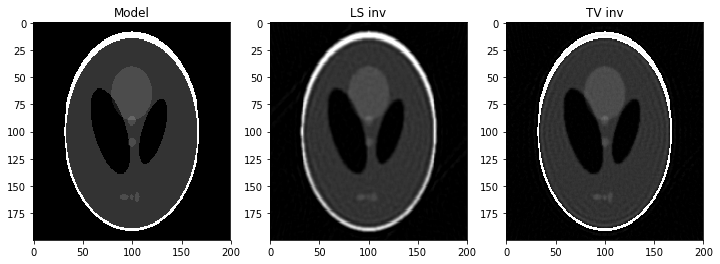

In [51]:
error_ls = image_l2 - image
error_tv = image_tv - image

print(f"L2 reconstruction error: {np.sqrt(np.mean(error_ls**2)):.3g}")
print(f"TV reconstruction error: {np.sqrt(np.mean(error_tv**2)):.3g}")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('LS inv')
axs[2].imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[2].set_title('TV inv');